In [14]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib as plt
import pandas as pd
import tensorflow as tf


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
base_dir = '/content/drive/MyDrive/images'
train_dir = '/content/drive/MyDrive/Choledoch_RGB_train'
validation_dir='/content/drive/MyDrive/Choledoch_RGB_validation'
train_L = os.path.join( train_dir, 'L')
train_N = os.path.join( train_dir, 'N')
train_P = os.path.join( train_dir, 'P')
validation_L = os.path.join(validation_dir,'L')
validation_N = os.path.join(validation_dir,'N')
validation_P = os.path.join(validation_dir,'P')
L_dir = '/content/drive/MyDrive/images/L/rgb'
N_dir = '/content/drive/MyDrive/images/N/rgb'
P_dir = '/content/drive/MyDrive/images/P/rgb'

In [17]:
from shutil import copyfile
import random
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    all_files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + '/'+ file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))
    
    n_files = len(all_files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled = random.sample(all_files,n_files)#shuffle them
    
    train_set = shuffled[:split_point]
    test_set = shuffled[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE +'/'+ file_name, TRAINING +'/'+ file_name)
        
    for file_name in test_set:
        copyfile(SOURCE +'/' +file_name, TESTING +'/' +file_name)


In [18]:
# split_data(L_dir, train_L,validation_L,0.9)
# split_data(N_dir, train_N,validation_N,0.9)
# split_data(P_dir, train_P,validation_P,0.9)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define the data augmentation pipeline
#data_augmentation = tf.keras.Sequential([
 # tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  #tf.keras.layers.experimental.preprocessing.RandomRotation(20),
  #tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  #tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
  #tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.05, width_factor=0.05),
  #tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
#])

Training_dir = '/content/drive/MyDrive/Choledoch_RGB_train'
Validation_dir = '/content/drive/MyDrive/Choledoch_RGB_validation'
training_datagen = ImageDataGenerator(rescale= 1./255,horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale= 1./255,horizontal_flip=True)
train_generator = training_datagen.flow_from_directory(Training_dir,target_size=(100, 150,),class_mode='categorical',batch_size=1)
validation_generator= validation_datagen.flow_from_directory(validation_dir,target_size=(100, 150,),class_mode='categorical',batch_size=1)

Found 792 images belonging to 3 classes.
Found 89 images belonging to 3 classes.


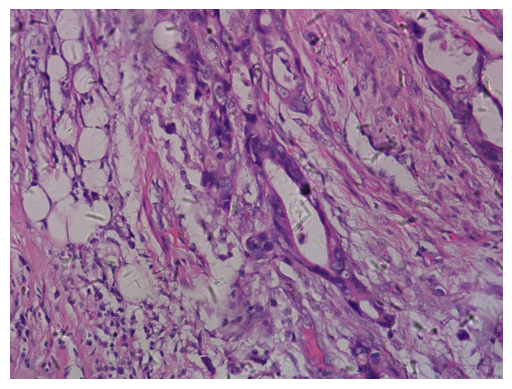

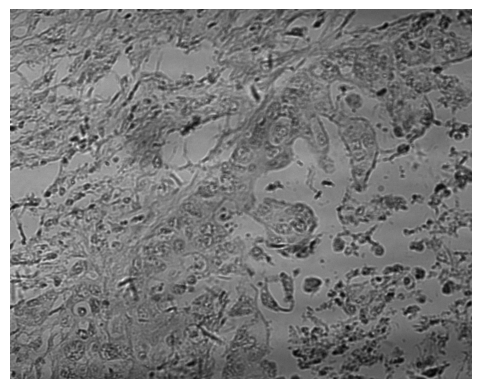

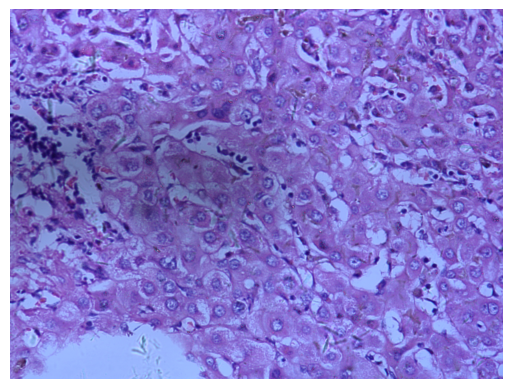

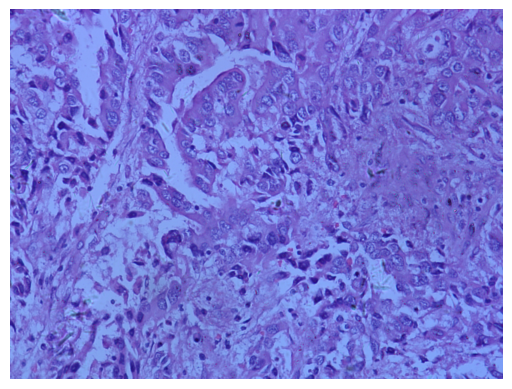

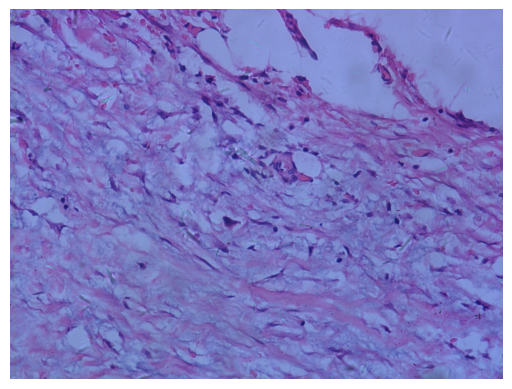

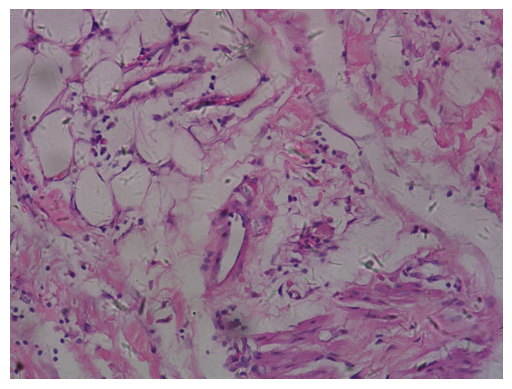

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
L_dir = '/content/drive/MyDrive/images/L/rgb'
N_dir = '/content/drive/MyDrive/images/N/rgb'
P_dir = '/content/drive/MyDrive/images/P/rgb'
L_files= os.listdir(L_dir)
N_files= os.listdir(N_dir)
P_files= os.listdir(P_dir)
pic_index = 4

"""
 next_L, next_N, and next_P are three separate lists, each containing the paths of two images from three different directories.
  The + operator is used to concatenate these three lists together into a single list, which contains all six image paths.
"""
next_L = [os.path.join(L_dir, fname) 
                for fname in L_files[pic_index-2:pic_index]]
next_N = [os.path.join(N_dir, fname) 
                for fname in N_files[pic_index-2:pic_index]]
next_P = [os.path.join(P_dir, fname) 
                for fname in P_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_L+next_N+next_P):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [21]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers


# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (100, 150, 3), 
                                include_top = False)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [22]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 4, 7, 768)


In [23]:

from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
# Flatten the output layer to 1 dimension
x = layers.Dropout(0.5)(last_output)  
x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)  
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(528, activation='relu',kernel_regularizer=l2(0.01))(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.3)(x)     
x = layers.Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x)      
x = layers.Dropout(0.3)(x)    
# Add a final sigmoid layer for classification
x = layers.Dense  (3, activation='softmax')(x)             

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 49, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 49, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [24]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [25]:
import matplotlib.pyplot as plt

# Train the model and store the training history
history = model.fit(train_generator, epochs=20, verbose=1, shuffle=True, validation_data = validation_generator)



Epoch 1/20
792/792 [==============================] - 288s 357ms/step - loss: 1.9923 - accuracy: 0.7525 - val_loss: 1.3518 - val_accuracy: 0.7753
Epoch 2/20
792/792 [==============================] - 73s 93ms/step - loss: 1.3004 - accuracy: 0.7879 - val_loss: 1.0881 - val_accuracy: 0.8315
Epoch 3/20
792/792 [==============================] - 69s 87ms/step - loss: 1.2326 - accuracy: 0.7828 - val_loss: 0.9876 - val_accuracy: 0.7753
Epoch 4/20
792/792 [==============================] - 69s 87ms/step - loss: 0.9834 - accuracy: 0.7803 - val_loss: 0.8193 - val_accuracy: 0.7753
Epoch 5/20
792/792 [==============================] - 69s 87ms/step - loss: 0.9531 - accuracy: 0.7917 - val_loss: 0.7858 - val_accuracy: 0.8090
Epoch 6/20
792/792 [==============================] - 69s 87ms/step - loss: 0.8482 - accuracy: 0.8018 - val_loss: 0.7181 - val_accuracy: 0.7753
Epoch 7/20
792/792 [==============================] - 69s 87ms/step - loss: 0.7897 - accuracy: 0.7967 - val_loss: 0.6753 - val_accurac

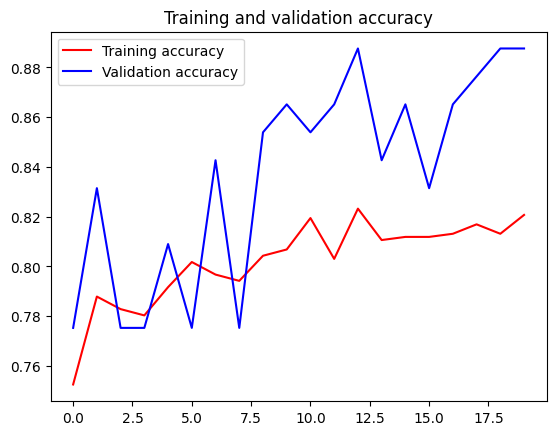

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [32]:
# Evaluate the model on the test set
# note, this is wrong because N and P are empty so in reality it is only testing how well it knows L
# what is good to know is that the model is brave enough to predict other than 0 
test_loss, test_acc = model.evaluate(validation_generator)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

89/89 [==============================] - 10s 109ms/step - loss: 0.5836 - accuracy: 0.8876
Test loss: 0.5835500359535217
Test accuracy: 0.8876404762268066


In [33]:
import numpy as np
#run code below first
#images is all the P values in training set
#what's nice to see is that the model is capable of predicting class 2 :)

y_pred = model.predict(validation_generator)
print(y_pred)
y_pred_labels = np.argmax(y_pred, axis=-1)
print(y_pred_labels)


89/89 [==============================] - 7s 81ms/step
[[0.88645166 0.02553265 0.08801574]
 [0.9031116  0.0204346  0.07645377]
 [0.88427466 0.02567872 0.0900467 ]
 [0.910815   0.01790443 0.07128049]
 [0.9413955  0.00999794 0.04860647]
 [0.3172312  0.12995802 0.5528107 ]
 [0.9462223  0.00883667 0.04494101]
 [0.80421966 0.05115173 0.14462869]
 [0.8422862  0.0402383  0.11747544]
 [0.79058135 0.06028184 0.14913677]
 [0.9311149  0.01264537 0.05623969]
 [0.7042693  0.0626721  0.23305863]
 [0.9302294  0.01285139 0.05691922]
 [0.9481649  0.00843511 0.04339999]
 [0.92612535 0.01379259 0.0600821 ]
 [0.9012247  0.02047125 0.07830404]
 [0.95193905 0.00770351 0.04035741]
 [0.9579914  0.00611022 0.03589831]
 [0.94649583 0.00861507 0.04488906]
 [0.8839307  0.02584638 0.09022301]
 [0.9304818  0.01269946 0.05681876]
 [0.8745132  0.02931082 0.09617593]
 [0.41243562 0.11240104 0.47516334]
 [0.79212064 0.053692   0.15418735]
 [0.91494954 0.01719282 0.0678577 ]
 [0.89954364 0.02140229 0.07905403]
 [0.887055

In [29]:
num_classes = 3
class_names = validation_generator.class_indices.keys()  # Get the class names
y_true_labels = []  # Create an empty list to store the true labels
for i in range(len(validation_generator)):
    batch_images, batch_labels = validation_generator.next()
    batch_size = batch_images.shape[0]
    for j in range(batch_size):
        class_index = np.argmax(batch_labels[j])
        y_true_labels.append(class_index)
print(y_true_labels)

[2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2]
